# Fast training with MONAI features

This tutorial shows a regular PyTorch training program and a MONAI optimized training program, and compared the performance.  
Mainly includes:
1. AMP (Auto mixed precision).
2. CacheDataset for deterministic transforms.
3. Move data to GPU and cache, then execute random transforms on GPU.
4. multi-threads `ThreadDataLoader` is faster than PyTorch DataLoader in light-weight task.
5. Use MONAI `DiceCE` loss instead of regular `Dice` loss.
6. Use MONAI `Novograd` optimizer instead of regular `Adam` optimizer.

With a V100 GPU, we are able to obtain approximately `12x` speedup compared with a Pytorch native implementation when the training converges at a validation mean dice of `0.95`.

It's modified from the Spleen 3D segmentation tutorial notebook, the Spleen dataset can be downloaded from http://medicaldecathlon.com/.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/acceleration/fast_training_tutorial.ipynb)

## Setup environment

In [2]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


## Setup imports

In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import glob
import math
import os
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import torch
from torch.optim import Adam
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import (
    CacheDataset,
    DataLoader,
    ThreadDataLoader,
    Dataset,
    decollate_batch,
)
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, DiceCELoss
from monai.metrics import DiceMetric
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.optimizers import Novograd
from monai.transforms import (
    AddChanneld,
    AsDiscrete,
    Compose,
    CropForegroundd,
    FgBgToIndicesd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToDeviced,
    EnsureTyped,
    EnsureType,
)
from monai.utils import get_torch_version_tuple, set_determinism

print_config()

if get_torch_version_tuple() < (1, 6):
    raise RuntimeError(
        "AMP feature only exists in PyTorch version greater than v1.6."
    )

MONAI version: 0.4.0+618.g69b44596
Numpy version: 1.20.3
Pytorch version: 1.9.0a0+c3d40fd
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 69b4459650fb6943b9e729e724254d2db2b2a1f2

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 3.2.1
scikit-image version: 0.15.0
Pillow version: 8.3.1
Tensorboard version: 2.5.0
gdown version: 3.13.0
TorchVision version: 0.10.0a0
tqdm version: 4.53.0
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.1.4
einops version: 0.3.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(f"root dir is: {root_dir}")

root dir is: /workspace/data/medical


## Download dataset

Downloads and extracts the Decathlon Spleen dataset.

In [3]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_root = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_root):
    download_and_extract(resource, compressed_file, root_dir, md5)

## Set MSD Spleen dataset path

In [4]:
train_images = sorted(
    glob.glob(os.path.join(data_root, "imagesTr", "*.nii.gz"))
)
train_labels = sorted(
    glob.glob(os.path.join(data_root, "labelsTr", "*.nii.gz"))
)
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Setup transforms for training and validation

In [5]:
def transformations(fast=False):
    train_transforms = [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        # pre-compute foreground and background indexes
        # and cache them to accelerate training
        FgBgToIndicesd(
            keys="label",
            fg_postfix="_fg",
            bg_postfix="_bg",
            image_key="image",
        ),
        EnsureTyped(keys=["image", "label"]),
    ]
    if fast:
        # move the data to GPU and cache to avoid CPU -> GPU sync in every epoch
        train_transforms.append(
            ToDeviced(keys=["image", "label"], device="cuda:0")
        )
    train_transforms.append(
        # randomly crop out patch samples from big
        # image based on pos / neg ratio
        # the image centers of negative samples
        # must be in valid image area
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            fg_indices_key="label_fg",
            bg_indices_key="label_bg",
        )
    )

    val_transforms = [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
    if fast:
        # move the data to GPU and cache to avoid CPU -> GPU sync in every epoch
        val_transforms.append(
            ToDeviced(keys=["image", "label"], device="cuda:0")
        )

    return Compose(train_transforms), Compose(val_transforms)

## Define the training progress
For a typical PyTorch regular training procedure, use regular `Dataset`, `DataLoader`, `Adam` optimizer and `Dice` loss to train the model.

For MONAI fast training progress, we mainly introduce the following features:
1. `AMP` (auto mixed precision): AMP is an important feature released in PyTorch v1.6, NVIDIA CUDA 11 added strong support for AMP and significantly improved training speed.
2. `CacheDataset`: Dataset with the cache mechanism that can load data and cache deterministic transforms' result during training.
3. `ToDeviced` transform: to move data to GPU and cache with `CacheDataset`, then execute random transforms on GPU directly, avoid CPU -> GPU sync in every epoch. Please note that not all the MONAI transforms support GPU operation so far, still working in progress.
4. `ThreadDataLoader`: uses multi-threads instead of multi-processing, faster than `DataLoader` in light-weight task as we already cached the results of most computation.
5. `Novograd` optimizer: Novograd is based on the paper "Stochastic Gradient Methods with Layer-wise Adaptive Moments for Training of Deep Networks" `<https://arxiv.org/pdf/1905.11286.pdf>`.
6. `DiceCE` loss function: computes Dice loss and Cross Entropy Loss, returns the weighted sum of these two losses.

In [6]:
def train_process(fast=False):
    max_epochs = 200
    learning_rate = 2e-4
    val_interval = 1  # do validation for every epoch

    train_trans, val_trans = transformations(fast=fast)
    # set CacheDataset, ThreadDataLoader and DiceCE loss for MONAI fast training
    if fast:
        train_ds = CacheDataset(
            data=train_files,
            transform=train_trans,
            cache_rate=1.0,
            num_workers=8,
        )
        val_ds = CacheDataset(
            data=val_files, transform=val_trans, cache_rate=1.0, num_workers=5
        )
        # disable multi-workers because `ThreadDataLoader` works with multi-threads
        train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=4, shuffle=True)
        val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)
        loss_function = DiceCELoss(to_onehot_y=True, softmax=True, squared_pred=True, batch=True)
    else:
        train_ds = Dataset(data=train_files, transform=train_trans)
        val_ds = Dataset(data=val_files, transform=val_trans)
        # num_worker=4 is the best parameter according to the test
        train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)
        loss_function = DiceLoss(to_onehot_y=True, softmax=True)

    device = torch.device("cuda:0")
    model = UNet(
        dimensions=3,
        in_channels=1,
        out_channels=2,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)

    post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, n_classes=2)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, n_classes=2)])

    dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

    # set Novograd optimizer for MONAI training
    if fast:
        # Novograd paper suggests to use a bigger LR than Adam,
        # because Adam does normalization by element-wise second moments
        optimizer = Novograd(model.parameters(), learning_rate * 10)
        scaler = torch.cuda.amp.GradScaler()
    else:
        optimizer = Adam(model.parameters(), learning_rate)

    best_metric = -1
    best_metric_epoch = -1
    best_metrics_epochs_and_time = [[], [], []]
    epoch_loss_values = []
    metric_values = []
    epoch_times = []
    total_start = time.time()
    for epoch in range(max_epochs):
        epoch_start = time.time()
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step_start = time.time()
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            # set AMP for MONAI training
            if fast:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = loss_function(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
            epoch_loss += loss.item()
            epoch_len = math.ceil(len(train_ds) / train_loader.batch_size)
            print(
                f"{step}/{epoch_len}, train_loss: {loss.item():.4f}"
                f" step time: {(time.time() - step_start):.4f}"
            )
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    roi_size = (160, 160, 160)
                    sw_batch_size = 4
                    # set AMP for MONAI validation
                    if fast:
                        with torch.cuda.amp.autocast():
                            val_outputs = sliding_window_inference(
                                val_inputs, roi_size, sw_batch_size, model
                            )
                    else:
                        val_outputs = sliding_window_inference(
                            val_inputs, roi_size, sw_batch_size, model
                        )
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    dice_metric(y_pred=val_outputs, y=val_labels)

                metric = dice_metric.aggregate().item()
                dice_metric.reset()
                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    best_metrics_epochs_and_time[0].append(best_metric)
                    best_metrics_epochs_and_time[1].append(best_metric_epoch)
                    best_metrics_epochs_and_time[2].append(
                        time.time() - total_start
                    )
                    torch.save(model.state_dict(), "best_metric_model.pth")
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current"
                    f" mean dice: {metric:.4f}"
                    f" best mean dice: {best_metric:.4f}"
                    f" at epoch: {best_metric_epoch}"
                )
        print(
            f"time consuming of epoch {epoch + 1} is:"
            f" {(time.time() - epoch_start):.4f}"
        )
        epoch_times.append(time.time() - epoch_start)

    total_time = time.time() - total_start
    print(
        f"train completed, best_metric: {best_metric:.4f}"
        f" at epoch: {best_metric_epoch}"
        f" total time: {total_time:.4f}"
    )
    return (
        max_epochs,
        epoch_loss_values,
        metric_values,
        epoch_times,
        best_metrics_epochs_and_time,
        total_time,
    )

## Enable determinism and execute regular PyTorch training

In [8]:
set_determinism(seed=0)
regular_start = time.time()
(
    epoch_num,
    epoch_loss_values,
    metric_values,
    epoch_times,
    best,
    train_time,
) = train_process(fast=False)
total_time = time.time() - regular_start
print(
    f"total time of {epoch_num} epochs with regular PyTorch training: {total_time:.4f}"
)

Loading dataset: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]

----------
epoch 1/200


1/8, train_loss: 0.6697 step time: 1.0725
2/8, train_loss: 0.6850 step time: 1.0517
3/8, train_loss: 0.6906 step time: 1.0499
4/8, train_loss: 0.6770 step time: 1.0483
5/8, train_loss: 0.6635 step time: 1.0487
6/8, train_loss: 0.6723 step time: 1.0470
7/8, train_loss: 0.6568 step time: 1.0512
8/8, train_loss: 0.6648 step time: 1.0498
epoch 1 average loss: 0.6725
saved new best metric model
current epoch: 1 current mean dice: 0.0395 best mean dice: 0.0395 at epoch: 1
time consuming of epoch 1 is: 19.6737
----------
epoch 2/200
1/8, train_loss: 0.6385 step time: 1.0563
2/8, train_loss: 0.6475 step time: 1.0508
3/8, train_loss: 0.6487 step time: 1.0510
4/8, train_loss: 0.6519 step time: 1.0519
5/8, train_loss: 0.6361 step time: 1.0490
6/8, train_loss: 0.6250 step time: 1.0486
7/8, train_loss: 0.6446 step time: 1.0507
8/8, train_loss: 0.6398 step time: 1.0488
epoch 2 average loss: 0.6415
saved new best metric model
current epoch: 2 current mean dice: 0.2744 best mean dice: 0.2744 at epoch:

8/8, train_loss: 0.4814 step time: 1.1626
epoch 16 average loss: 0.5197
current epoch: 16 current mean dice: 0.4722 best mean dice: 0.5171 at epoch: 14
time consuming of epoch 16 is: 21.5712
----------
epoch 17/200
1/8, train_loss: 0.5299 step time: 1.1273
2/8, train_loss: 0.5473 step time: 1.1474
3/8, train_loss: 0.5154 step time: 1.1568
4/8, train_loss: 0.4614 step time: 1.1657
5/8, train_loss: 0.5388 step time: 1.1385
6/8, train_loss: 0.5182 step time: 1.1426
7/8, train_loss: 0.5081 step time: 1.1506
8/8, train_loss: 0.5450 step time: 1.1496
epoch 17 average loss: 0.5205
saved new best metric model
current epoch: 17 current mean dice: 0.5327 best mean dice: 0.5327 at epoch: 17
time consuming of epoch 17 is: 21.7611
----------
epoch 18/200
1/8, train_loss: 0.5048 step time: 1.1003
2/8, train_loss: 0.5401 step time: 1.1390
3/8, train_loss: 0.5390 step time: 1.1453
4/8, train_loss: 0.5273 step time: 1.1490
5/8, train_loss: 0.4742 step time: 1.1269
6/8, train_loss: 0.5105 step time: 1.1

8/8, train_loss: 0.4476 step time: 1.1593
epoch 32 average loss: 0.4083
current epoch: 32 current mean dice: 0.3808 best mean dice: 0.5737 at epoch: 27
time consuming of epoch 32 is: 21.6815
----------
epoch 33/200
1/8, train_loss: 0.4291 step time: 1.1038
2/8, train_loss: 0.4356 step time: 1.1333
3/8, train_loss: 0.3676 step time: 1.1591
4/8, train_loss: 0.4117 step time: 1.1692
5/8, train_loss: 0.3995 step time: 1.1436
6/8, train_loss: 0.3509 step time: 1.1672
7/8, train_loss: 0.3763 step time: 1.1605
8/8, train_loss: 0.3629 step time: 1.1754
epoch 33 average loss: 0.3917
current epoch: 33 current mean dice: 0.3936 best mean dice: 0.5737 at epoch: 27
time consuming of epoch 33 is: 21.7978
----------
epoch 34/200
1/8, train_loss: 0.3540 step time: 1.1105
2/8, train_loss: 0.4361 step time: 1.1388
3/8, train_loss: 0.3682 step time: 1.1611
4/8, train_loss: 0.3610 step time: 1.1621
5/8, train_loss: 0.3613 step time: 1.7860
6/8, train_loss: 0.3437 step time: 1.4237
7/8, train_loss: 0.4520 

current epoch: 48 current mean dice: 0.4067 best mean dice: 0.5737 at epoch: 27
time consuming of epoch 48 is: 22.1540
----------
epoch 49/200
1/8, train_loss: 0.3176 step time: 1.1125
2/8, train_loss: 0.3016 step time: 1.1002
3/8, train_loss: 0.3674 step time: 1.9414
4/8, train_loss: 0.3633 step time: 1.1899
5/8, train_loss: 0.3699 step time: 1.1279
6/8, train_loss: 0.2972 step time: 1.1327
7/8, train_loss: 0.3264 step time: 1.1553
8/8, train_loss: 0.2829 step time: 1.1589
epoch 49 average loss: 0.3283
current epoch: 49 current mean dice: 0.3648 best mean dice: 0.5737 at epoch: 27
time consuming of epoch 49 is: 22.4631
----------
epoch 50/200
1/8, train_loss: 0.2891 step time: 1.0960
2/8, train_loss: 0.2988 step time: 1.1432
3/8, train_loss: 0.3184 step time: 1.1691
4/8, train_loss: 0.3188 step time: 1.1712
5/8, train_loss: 0.2767 step time: 1.1569
6/8, train_loss: 0.2842 step time: 1.1485
7/8, train_loss: 0.3129 step time: 1.1507
8/8, train_loss: 0.3608 step time: 1.1543
epoch 50 ave

1/8, train_loss: 0.3687 step time: 1.1183
2/8, train_loss: 0.2877 step time: 1.1155
3/8, train_loss: 0.2899 step time: 1.1698
4/8, train_loss: 0.2545 step time: 1.1579
5/8, train_loss: 0.3479 step time: 1.1495
6/8, train_loss: 0.2765 step time: 1.1687
7/8, train_loss: 0.2937 step time: 1.1522
8/8, train_loss: 0.2499 step time: 1.1814
epoch 65 average loss: 0.2961
current epoch: 65 current mean dice: 0.4680 best mean dice: 0.5737 at epoch: 27
time consuming of epoch 65 is: 21.9494
----------
epoch 66/200
1/8, train_loss: 0.2960 step time: 1.1261
2/8, train_loss: 0.2324 step time: 1.1576
3/8, train_loss: 0.2679 step time: 1.1748
4/8, train_loss: 0.3892 step time: 1.1655
5/8, train_loss: 0.2736 step time: 1.1723
6/8, train_loss: 0.3434 step time: 1.1636
7/8, train_loss: 0.2966 step time: 1.1788
8/8, train_loss: 0.2606 step time: 1.1701
epoch 66 average loss: 0.2950
current epoch: 66 current mean dice: 0.3816 best mean dice: 0.5737 at epoch: 27
time consuming of epoch 66 is: 22.1810
------

3/8, train_loss: 0.2816 step time: 1.1910
4/8, train_loss: 0.3191 step time: 1.1922
5/8, train_loss: 0.2834 step time: 1.1616
6/8, train_loss: 0.2760 step time: 1.1781
7/8, train_loss: 0.2633 step time: 1.1851
8/8, train_loss: 0.2876 step time: 1.1765
epoch 81 average loss: 0.2964
current epoch: 81 current mean dice: 0.4217 best mean dice: 0.5737 at epoch: 27
time consuming of epoch 81 is: 22.0517
----------
epoch 82/200
1/8, train_loss: 0.2360 step time: 1.1306
2/8, train_loss: 0.3310 step time: 1.1888
3/8, train_loss: 0.2816 step time: 1.1797
4/8, train_loss: 0.3154 step time: 1.1713
5/8, train_loss: 0.2722 step time: 1.1816
6/8, train_loss: 0.2737 step time: 1.1833
7/8, train_loss: 0.2518 step time: 1.1719
8/8, train_loss: 0.2474 step time: 1.1990
epoch 82 average loss: 0.2761
current epoch: 82 current mean dice: 0.3749 best mean dice: 0.5737 at epoch: 27
time consuming of epoch 82 is: 22.1884
----------
epoch 83/200
1/8, train_loss: 0.2758 step time: 1.1317
2/8, train_loss: 0.2609 

5/8, train_loss: 0.2555 step time: 1.1686
6/8, train_loss: 0.2208 step time: 1.2273
7/8, train_loss: 0.1549 step time: 1.3657
8/8, train_loss: 0.2726 step time: 1.2197
epoch 97 average loss: 0.2372
current epoch: 97 current mean dice: 0.3843 best mean dice: 0.5737 at epoch: 27
time consuming of epoch 97 is: 22.4050
----------
epoch 98/200
1/8, train_loss: 0.1645 step time: 1.1198
2/8, train_loss: 0.2713 step time: 1.1196
3/8, train_loss: 0.1580 step time: 1.1601
4/8, train_loss: 0.1907 step time: 1.1586
5/8, train_loss: 0.1917 step time: 1.1595
6/8, train_loss: 0.2341 step time: 1.1816
7/8, train_loss: 0.2220 step time: 1.1673
8/8, train_loss: 0.1815 step time: 1.1683
epoch 98 average loss: 0.2017
current epoch: 98 current mean dice: 0.4017 best mean dice: 0.5737 at epoch: 27
time consuming of epoch 98 is: 21.9320
----------
epoch 99/200
1/8, train_loss: 0.1774 step time: 1.1208
2/8, train_loss: 0.2093 step time: 1.1525
3/8, train_loss: 0.2026 step time: 1.1632
4/8, train_loss: 0.1976 

5/8, train_loss: 0.1622 step time: 1.1662
6/8, train_loss: 0.1781 step time: 1.1688
7/8, train_loss: 0.1876 step time: 1.1647
8/8, train_loss: 0.2121 step time: 1.1616
epoch 113 average loss: 0.2067
current epoch: 113 current mean dice: 0.4656 best mean dice: 0.5737 at epoch: 27
time consuming of epoch 113 is: 21.7817
----------
epoch 114/200
1/8, train_loss: 0.2018 step time: 1.1577
2/8, train_loss: 0.1862 step time: 1.2252
3/8, train_loss: 0.2431 step time: 1.1747
4/8, train_loss: 0.1786 step time: 1.1835
5/8, train_loss: 0.2240 step time: 1.1651
6/8, train_loss: 0.2929 step time: 1.1634
7/8, train_loss: 0.2054 step time: 1.2261
8/8, train_loss: 0.2919 step time: 1.2773
epoch 114 average loss: 0.2280
current epoch: 114 current mean dice: 0.5398 best mean dice: 0.5737 at epoch: 27
time consuming of epoch 114 is: 22.0781
----------
epoch 115/200
1/8, train_loss: 0.1525 step time: 1.1096
2/8, train_loss: 0.2890 step time: 1.1116
3/8, train_loss: 0.2551 step time: 1.1604
4/8, train_loss:

5/8, train_loss: 0.2251 step time: 1.1354
6/8, train_loss: 0.1503 step time: 1.1688
7/8, train_loss: 0.3744 step time: 1.1759
8/8, train_loss: 0.2286 step time: 1.1652
epoch 129 average loss: 0.2295
current epoch: 129 current mean dice: 0.4952 best mean dice: 0.5737 at epoch: 27
time consuming of epoch 129 is: 21.8654
----------
epoch 130/200
1/8, train_loss: 0.1678 step time: 1.1596
2/8, train_loss: 0.2013 step time: 1.1783
3/8, train_loss: 0.2581 step time: 1.1614
4/8, train_loss: 0.2825 step time: 1.1534
5/8, train_loss: 0.1400 step time: 1.1366
6/8, train_loss: 0.2534 step time: 1.1372
7/8, train_loss: 0.1735 step time: 1.1370
8/8, train_loss: 0.2262 step time: 1.2090
epoch 130 average loss: 0.2128
current epoch: 130 current mean dice: 0.4616 best mean dice: 0.5737 at epoch: 27
time consuming of epoch 130 is: 21.7070
----------
epoch 131/200
1/8, train_loss: 0.2632 step time: 1.1144
2/8, train_loss: 0.2514 step time: 1.1444
3/8, train_loss: 0.2786 step time: 1.1585
4/8, train_loss:

5/8, train_loss: 0.1874 step time: 1.1687
6/8, train_loss: 0.1944 step time: 1.1405
7/8, train_loss: 0.2271 step time: 1.1635
8/8, train_loss: 0.2505 step time: 1.1857
epoch 145 average loss: 0.2152
current epoch: 145 current mean dice: 0.5407 best mean dice: 0.5737 at epoch: 27
time consuming of epoch 145 is: 21.7994
----------
epoch 146/200
1/8, train_loss: 0.0971 step time: 1.1348
2/8, train_loss: 0.2188 step time: 1.1430
3/8, train_loss: 0.2990 step time: 1.1610
4/8, train_loss: 0.1453 step time: 1.2164
5/8, train_loss: 0.2256 step time: 1.1676
6/8, train_loss: 0.2760 step time: 1.1758
7/8, train_loss: 0.2098 step time: 1.1827
8/8, train_loss: 0.2263 step time: 1.1838
epoch 146 average loss: 0.2122
current epoch: 146 current mean dice: 0.5081 best mean dice: 0.5737 at epoch: 27
time consuming of epoch 146 is: 22.0338
----------
epoch 147/200
1/8, train_loss: 0.2070 step time: 1.1167
2/8, train_loss: 0.2145 step time: 1.1693
3/8, train_loss: 0.2175 step time: 1.3088
4/8, train_loss:

5/8, train_loss: 0.1730 step time: 1.1389
6/8, train_loss: 0.1619 step time: 1.1468
7/8, train_loss: 0.2468 step time: 1.1664
8/8, train_loss: 0.1417 step time: 1.1759
epoch 161 average loss: 0.1875
current epoch: 161 current mean dice: 0.4930 best mean dice: 0.5737 at epoch: 27
time consuming of epoch 161 is: 21.9083
----------
epoch 162/200
1/8, train_loss: 0.1269 step time: 1.1210
2/8, train_loss: 0.1855 step time: 1.1279
3/8, train_loss: 0.1341 step time: 1.1726
4/8, train_loss: 0.2536 step time: 1.1681
5/8, train_loss: 0.2236 step time: 1.1560
6/8, train_loss: 0.1993 step time: 1.3233
7/8, train_loss: 0.1635 step time: 1.3461
8/8, train_loss: 0.1323 step time: 1.1860
epoch 162 average loss: 0.1773
current epoch: 162 current mean dice: 0.5313 best mean dice: 0.5737 at epoch: 27
time consuming of epoch 162 is: 22.2784
----------
epoch 163/200
1/8, train_loss: 0.2459 step time: 1.1283
2/8, train_loss: 0.2642 step time: 1.1156
3/8, train_loss: 0.1895 step time: 1.1613
4/8, train_loss:

3/8, train_loss: 0.2302 step time: 1.1673
4/8, train_loss: 0.2408 step time: 1.1473
5/8, train_loss: 0.1403 step time: 1.1412
6/8, train_loss: 0.2230 step time: 1.1529
7/8, train_loss: 0.1824 step time: 1.1372
8/8, train_loss: 0.1487 step time: 1.1599
epoch 177 average loss: 0.1951
current epoch: 177 current mean dice: 0.5531 best mean dice: 0.6246 at epoch: 172
time consuming of epoch 177 is: 21.6503
----------
epoch 178/200
1/8, train_loss: 0.1528 step time: 1.1013
2/8, train_loss: 0.2454 step time: 1.6039
3/8, train_loss: 0.2498 step time: 1.3743
4/8, train_loss: 0.1287 step time: 1.1700
5/8, train_loss: 0.1212 step time: 1.1225
6/8, train_loss: 0.1028 step time: 1.1801
7/8, train_loss: 0.2196 step time: 1.2403
8/8, train_loss: 0.1508 step time: 1.1699
epoch 178 average loss: 0.1714
saved new best metric model
current epoch: 178 current mean dice: 0.6361 best mean dice: 0.6361 at epoch: 178
time consuming of epoch 178 is: 22.4816
----------
epoch 179/200
1/8, train_loss: 0.2146 step

1/8, train_loss: 0.1790 step time: 1.0917
2/8, train_loss: 0.1916 step time: 1.1436
3/8, train_loss: 0.2223 step time: 1.1516
4/8, train_loss: 0.1224 step time: 1.1755
5/8, train_loss: 0.1468 step time: 1.2176
6/8, train_loss: 0.3036 step time: 1.1830
7/8, train_loss: 0.1606 step time: 1.1411
8/8, train_loss: 0.1462 step time: 1.1403
epoch 193 average loss: 0.1841
current epoch: 193 current mean dice: 0.8294 best mean dice: 0.9016 at epoch: 185
time consuming of epoch 193 is: 21.5896
----------
epoch 194/200
1/8, train_loss: 0.1258 step time: 1.1251
2/8, train_loss: 0.3020 step time: 1.1078
3/8, train_loss: 0.1818 step time: 1.1444
4/8, train_loss: 0.3018 step time: 1.1517
5/8, train_loss: 0.2451 step time: 1.1399
6/8, train_loss: 0.0745 step time: 1.1564
7/8, train_loss: 0.1476 step time: 1.1539
8/8, train_loss: 0.2385 step time: 1.1521
epoch 194 average loss: 0.2022
saved new best metric model
current epoch: 194 current mean dice: 0.9477 best mean dice: 0.9477 at epoch: 194
time cons

## Enable determinism and execute MONAI optimized training

In [7]:
set_determinism(seed=0)
monai_start = time.time()
(
    epoch_num,
    m_epoch_loss_values,
    m_metric_values,
    m_epoch_times,
    m_best,
    m_train_time,
) = train_process(fast=True)
m_total_time = time.time() - monai_start
print(
    f"total time of {epoch_num} epochs with MONAI fast training: {m_train_time:.4f},"
    f" time of preparing cache: {(m_total_time - m_train_time):.4f}"
)

Loading dataset: 100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


----------
epoch 1/200
1/8, train_loss: 1.5943 step time: 1.2531
2/8, train_loss: 1.5951 step time: 0.1818
3/8, train_loss: 1.5598 step time: 0.1829
4/8, train_loss: 1.5465 step time: 0.1814
5/8, train_loss: 1.4930 step time: 0.1821
6/8, train_loss: 1.4714 step time: 0.1828
7/8, train_loss: 1.4303 step time: 0.1814
8/8, train_loss: 1.3682 step time: 0.1818
epoch 1 average loss: 1.5073
saved new best metric model
current epoch: 1 current mean dice: 0.4133 best mean dice: 0.4133 at epoch: 1
time consuming of epoch 1 is: 3.9301
----------
epoch 2/200
1/8, train_loss: 1.3381 step time: 0.1817
2/8, train_loss: 1.2778 step time: 0.1830
3/8, train_loss: 1.2425 step time: 0.1816
4/8, train_loss: 1.2007 step time: 0.1825
5/8, train_loss: 1.1295 step time: 0.1833
6/8, train_loss: 1.0935 step time: 0.1802
7/8, train_loss: 1.0546 step time: 0.1816
8/8, train_loss: 0.9958 step time: 0.1805
epoch 2 average loss: 1.1666
saved new best metric model
current epoch: 2 current mean dice: 0.5098 best mean 

1/8, train_loss: 0.1861 step time: 0.1816
2/8, train_loss: 0.0996 step time: 0.1807
3/8, train_loss: 0.0830 step time: 0.1831
4/8, train_loss: 0.1173 step time: 0.1818
5/8, train_loss: 0.0772 step time: 0.1817
6/8, train_loss: 0.0838 step time: 0.1816
7/8, train_loss: 0.0630 step time: 0.1822
8/8, train_loss: 0.0598 step time: 0.1809
epoch 17 average loss: 0.0962
current epoch: 17 current mean dice: 0.7106 best mean dice: 0.8904 at epoch: 16
time consuming of epoch 17 is: 2.8177
----------
epoch 18/200
1/8, train_loss: 0.0890 step time: 0.1813
2/8, train_loss: 0.0907 step time: 0.1835
3/8, train_loss: 0.0930 step time: 0.1838
4/8, train_loss: 0.0873 step time: 0.1816
5/8, train_loss: 0.1194 step time: 0.1824
6/8, train_loss: 0.0564 step time: 0.1821
7/8, train_loss: 0.0929 step time: 0.1818
8/8, train_loss: 0.0893 step time: 0.1817
epoch 18 average loss: 0.0897
saved new best metric model
current epoch: 18 current mean dice: 0.9073 best mean dice: 0.9073 at epoch: 18
time consuming of 

1/8, train_loss: 0.0370 step time: 0.1821
2/8, train_loss: 0.0351 step time: 0.1816
3/8, train_loss: 0.0535 step time: 0.1836
4/8, train_loss: 0.0385 step time: 0.1811
5/8, train_loss: 0.0380 step time: 0.1813
6/8, train_loss: 0.0281 step time: 0.1815
7/8, train_loss: 0.0363 step time: 0.1818
8/8, train_loss: 0.0527 step time: 0.1820
epoch 33 average loss: 0.0399
current epoch: 33 current mean dice: 0.9033 best mean dice: 0.9591 at epoch: 32
time consuming of epoch 33 is: 2.8194
----------
epoch 34/200
1/8, train_loss: 0.0385 step time: 0.1823
2/8, train_loss: 0.0290 step time: 0.1814
3/8, train_loss: 0.0396 step time: 0.1816
4/8, train_loss: 0.0457 step time: 0.1820
5/8, train_loss: 0.0323 step time: 0.1816
6/8, train_loss: 0.0369 step time: 0.1829
7/8, train_loss: 0.0369 step time: 0.1819
8/8, train_loss: 0.0348 step time: 0.1819
epoch 34 average loss: 0.0367
saved new best metric model
current epoch: 34 current mean dice: 0.9596 best mean dice: 0.9596 at epoch: 34
time consuming of 

1/8, train_loss: 0.0290 step time: 0.1833
2/8, train_loss: 0.1831 step time: 0.1817
3/8, train_loss: 0.1201 step time: 0.1809
4/8, train_loss: 0.0315 step time: 0.1822
5/8, train_loss: 0.0528 step time: 0.1836
6/8, train_loss: 0.0311 step time: 0.1826
7/8, train_loss: 0.0872 step time: 0.1816
8/8, train_loss: 0.0704 step time: 0.1818
epoch 49 average loss: 0.0757
current epoch: 49 current mean dice: 0.9319 best mean dice: 0.9661 at epoch: 43
time consuming of epoch 49 is: 2.8148
----------
epoch 50/200
1/8, train_loss: 0.0408 step time: 0.1817
2/8, train_loss: 0.0528 step time: 0.1827
3/8, train_loss: 0.0750 step time: 0.1824
4/8, train_loss: 0.0591 step time: 0.1819
5/8, train_loss: 0.0615 step time: 0.1815
6/8, train_loss: 0.0422 step time: 0.1819
7/8, train_loss: 0.0690 step time: 0.1819
8/8, train_loss: 0.0287 step time: 0.1819
epoch 50 average loss: 0.0536
current epoch: 50 current mean dice: 0.6982 best mean dice: 0.9661 at epoch: 43
time consuming of epoch 50 is: 2.8133
--------

2/8, train_loss: 0.0226 step time: 0.1813
3/8, train_loss: 0.0319 step time: 0.1820
4/8, train_loss: 0.0309 step time: 0.1829
5/8, train_loss: 0.0275 step time: 0.1818
6/8, train_loss: 0.0231 step time: 0.1821
7/8, train_loss: 0.0256 step time: 0.1817
8/8, train_loss: 0.0286 step time: 0.1819
epoch 65 average loss: 0.0281
saved new best metric model
current epoch: 65 current mean dice: 0.9681 best mean dice: 0.9681 at epoch: 65
time consuming of epoch 65 is: 2.8561
----------
epoch 66/200
1/8, train_loss: 0.0400 step time: 0.1816
2/8, train_loss: 0.0243 step time: 0.1827
3/8, train_loss: 0.0258 step time: 0.1819
4/8, train_loss: 0.0224 step time: 0.1820
5/8, train_loss: 0.0317 step time: 0.1815
6/8, train_loss: 0.0301 step time: 0.1832
7/8, train_loss: 0.0268 step time: 0.1812
8/8, train_loss: 0.0229 step time: 0.1818
epoch 66 average loss: 0.0280
current epoch: 66 current mean dice: 0.9677 best mean dice: 0.9681 at epoch: 65
time consuming of epoch 66 is: 2.8085
----------
epoch 67/20

3/8, train_loss: 0.0398 step time: 0.1826
4/8, train_loss: 0.0370 step time: 0.1818
5/8, train_loss: 0.0333 step time: 0.1818
6/8, train_loss: 0.0720 step time: 0.1826
7/8, train_loss: 0.1194 step time: 0.1817
8/8, train_loss: 0.0275 step time: 0.1796
epoch 81 average loss: 0.0488
current epoch: 81 current mean dice: 0.9603 best mean dice: 0.9681 at epoch: 65
time consuming of epoch 81 is: 2.8172
----------
epoch 82/200
1/8, train_loss: 0.0361 step time: 0.1822
2/8, train_loss: 0.0552 step time: 0.1806
3/8, train_loss: 0.0472 step time: 0.1817
4/8, train_loss: 0.0611 step time: 0.1820
5/8, train_loss: 0.0727 step time: 0.1819
6/8, train_loss: 0.0554 step time: 0.1826
7/8, train_loss: 0.0350 step time: 0.1820
8/8, train_loss: 0.0310 step time: 0.1821
epoch 82 average loss: 0.0492
current epoch: 82 current mean dice: 0.9174 best mean dice: 0.9681 at epoch: 65
time consuming of epoch 82 is: 2.8132
----------
epoch 83/200
1/8, train_loss: 0.0298 step time: 0.1816
2/8, train_loss: 0.0392 st

3/8, train_loss: 0.0229 step time: 0.1819
4/8, train_loss: 0.0276 step time: 0.1819
5/8, train_loss: 0.0288 step time: 0.1829
6/8, train_loss: 0.0224 step time: 0.1822
7/8, train_loss: 0.0274 step time: 0.1827
8/8, train_loss: 0.0239 step time: 0.1815
epoch 97 average loss: 0.0250
current epoch: 97 current mean dice: 0.9650 best mean dice: 0.9705 at epoch: 95
time consuming of epoch 97 is: 2.8104
----------
epoch 98/200
1/8, train_loss: 0.0327 step time: 0.1825
2/8, train_loss: 0.0269 step time: 0.1813
3/8, train_loss: 0.0256 step time: 0.1817
4/8, train_loss: 0.0215 step time: 0.1817
5/8, train_loss: 0.0210 step time: 0.1816
6/8, train_loss: 0.0282 step time: 0.1817
7/8, train_loss: 0.0222 step time: 0.1829
8/8, train_loss: 0.0258 step time: 0.1830
epoch 98 average loss: 0.0255
current epoch: 98 current mean dice: 0.9604 best mean dice: 0.9705 at epoch: 95
time consuming of epoch 98 is: 2.8153
----------
epoch 99/200
1/8, train_loss: 0.0230 step time: 0.1798
2/8, train_loss: 0.0254 st

3/8, train_loss: 0.0212 step time: 0.1817
4/8, train_loss: 0.0234 step time: 0.1818
5/8, train_loss: 0.0343 step time: 0.1818
6/8, train_loss: 0.0270 step time: 0.1832
7/8, train_loss: 0.0429 step time: 0.1827
8/8, train_loss: 0.0260 step time: 0.1827
epoch 113 average loss: 0.0279
current epoch: 113 current mean dice: 0.9648 best mean dice: 0.9713 at epoch: 102
time consuming of epoch 113 is: 2.8120
----------
epoch 114/200
1/8, train_loss: 0.0257 step time: 0.1818
2/8, train_loss: 0.0227 step time: 0.1818
3/8, train_loss: 0.0266 step time: 0.1827
4/8, train_loss: 0.0330 step time: 0.1821
5/8, train_loss: 0.0295 step time: 0.1818
6/8, train_loss: 0.0228 step time: 0.1814
7/8, train_loss: 0.0247 step time: 0.1818
8/8, train_loss: 0.0259 step time: 0.1819
epoch 114 average loss: 0.0264
current epoch: 114 current mean dice: 0.8589 best mean dice: 0.9713 at epoch: 102
time consuming of epoch 114 is: 2.8118
----------
epoch 115/200
1/8, train_loss: 0.0323 step time: 0.1815
2/8, train_loss:

3/8, train_loss: 0.0276 step time: 0.1814
4/8, train_loss: 0.0170 step time: 0.1818
5/8, train_loss: 0.0192 step time: 0.1817
6/8, train_loss: 0.0228 step time: 0.1819
7/8, train_loss: 0.0209 step time: 0.1817
8/8, train_loss: 0.0201 step time: 0.1812
epoch 129 average loss: 0.0226
current epoch: 129 current mean dice: 0.9674 best mean dice: 0.9713 at epoch: 102
time consuming of epoch 129 is: 2.7729
----------
epoch 130/200
1/8, train_loss: 0.0227 step time: 0.1813
2/8, train_loss: 0.0253 step time: 0.1816
3/8, train_loss: 0.0327 step time: 0.1816
4/8, train_loss: 0.0260 step time: 0.1829
5/8, train_loss: 0.0241 step time: 0.1830
6/8, train_loss: 0.0240 step time: 0.1822
7/8, train_loss: 0.0264 step time: 0.1825
8/8, train_loss: 0.0314 step time: 0.1816
epoch 130 average loss: 0.0266
current epoch: 130 current mean dice: 0.9699 best mean dice: 0.9713 at epoch: 102
time consuming of epoch 130 is: 2.8233
----------
epoch 131/200
1/8, train_loss: 0.0246 step time: 0.1815
2/8, train_loss:

1/8, train_loss: 0.0230 step time: 0.1811
2/8, train_loss: 0.0237 step time: 0.1815
3/8, train_loss: 0.0244 step time: 0.1829
4/8, train_loss: 0.0315 step time: 0.1816
5/8, train_loss: 0.0221 step time: 0.1830
6/8, train_loss: 0.0225 step time: 0.1757
7/8, train_loss: 0.0185 step time: 0.1827
8/8, train_loss: 0.0219 step time: 0.1821
epoch 145 average loss: 0.0235
current epoch: 145 current mean dice: 0.9690 best mean dice: 0.9729 at epoch: 143
time consuming of epoch 145 is: 2.8059
----------
epoch 146/200
1/8, train_loss: 0.0194 step time: 0.1812
2/8, train_loss: 0.0205 step time: 0.1816
3/8, train_loss: 0.0208 step time: 0.1820
4/8, train_loss: 0.0275 step time: 0.1821
5/8, train_loss: 0.0188 step time: 0.1819
6/8, train_loss: 0.0261 step time: 0.1818
7/8, train_loss: 0.0240 step time: 0.1816
8/8, train_loss: 0.0228 step time: 0.1804
epoch 146 average loss: 0.0225
current epoch: 146 current mean dice: 0.9709 best mean dice: 0.9729 at epoch: 143
time consuming of epoch 146 is: 2.8147

1/8, train_loss: 0.0241 step time: 0.1824
2/8, train_loss: 0.0284 step time: 0.1820
3/8, train_loss: 0.0251 step time: 0.1820
4/8, train_loss: 0.0185 step time: 0.1820
5/8, train_loss: 0.0190 step time: 0.1810
6/8, train_loss: 0.0207 step time: 0.1829
7/8, train_loss: 0.0183 step time: 0.1819
8/8, train_loss: 0.0222 step time: 0.1812
epoch 161 average loss: 0.0220
current epoch: 161 current mean dice: 0.9704 best mean dice: 0.9729 at epoch: 143
time consuming of epoch 161 is: 2.8203
----------
epoch 162/200
1/8, train_loss: 0.0170 step time: 0.1821
2/8, train_loss: 0.0202 step time: 0.1815
3/8, train_loss: 0.0222 step time: 0.1836
4/8, train_loss: 0.0215 step time: 0.1814
5/8, train_loss: 0.0250 step time: 0.1819
6/8, train_loss: 0.0222 step time: 0.1819
7/8, train_loss: 0.0236 step time: 0.1831
8/8, train_loss: 0.0233 step time: 0.1831
epoch 162 average loss: 0.0219
current epoch: 162 current mean dice: 0.9727 best mean dice: 0.9729 at epoch: 143
time consuming of epoch 162 is: 2.8224

1/8, train_loss: 0.0198 step time: 0.1931
2/8, train_loss: 0.0199 step time: 0.1903
3/8, train_loss: 0.0209 step time: 0.1922
4/8, train_loss: 0.0187 step time: 0.1890
5/8, train_loss: 0.0177 step time: 0.1852
6/8, train_loss: 0.0238 step time: 0.1859
7/8, train_loss: 0.0177 step time: 0.1847
8/8, train_loss: 0.0225 step time: 0.1858
epoch 177 average loss: 0.0201
current epoch: 177 current mean dice: 0.9711 best mean dice: 0.9731 at epoch: 173
time consuming of epoch 177 is: 2.9065
----------
epoch 178/200
1/8, train_loss: 0.0191 step time: 0.1972
2/8, train_loss: 0.0222 step time: 0.1966
3/8, train_loss: 0.0187 step time: 0.1936
4/8, train_loss: 0.0201 step time: 0.1945
5/8, train_loss: 0.0235 step time: 0.1872
6/8, train_loss: 0.0196 step time: 0.1901
7/8, train_loss: 0.0196 step time: 0.1839
8/8, train_loss: 0.0190 step time: 0.1839
epoch 178 average loss: 0.0202
current epoch: 178 current mean dice: 0.9728 best mean dice: 0.9731 at epoch: 173
time consuming of epoch 178 is: 2.9182

1/8, train_loss: 0.0223 step time: 0.1930
2/8, train_loss: 0.0218 step time: 0.1878
3/8, train_loss: 0.0228 step time: 0.1911
4/8, train_loss: 0.0187 step time: 0.1888
5/8, train_loss: 0.0213 step time: 0.1847
6/8, train_loss: 0.0250 step time: 0.1851
7/8, train_loss: 0.0210 step time: 0.1836
8/8, train_loss: 0.0181 step time: 0.1832
epoch 193 average loss: 0.0214
current epoch: 193 current mean dice: 0.9729 best mean dice: 0.9753 at epoch: 190
time consuming of epoch 193 is: 2.8846
----------
epoch 194/200
1/8, train_loss: 0.0188 step time: 0.6069
2/8, train_loss: 0.0186 step time: 0.2557
3/8, train_loss: 0.0234 step time: 0.2110
4/8, train_loss: 0.0196 step time: 0.2046
5/8, train_loss: 0.0182 step time: 0.1971
6/8, train_loss: 0.0235 step time: 0.1913
7/8, train_loss: 0.0222 step time: 0.1934
8/8, train_loss: 0.0189 step time: 0.1894
epoch 194 average loss: 0.0204
current epoch: 194 current mean dice: 0.9746 best mean dice: 0.9753 at epoch: 190
time consuming of epoch 194 is: 3.4627

## Plot training loss and validation metrics

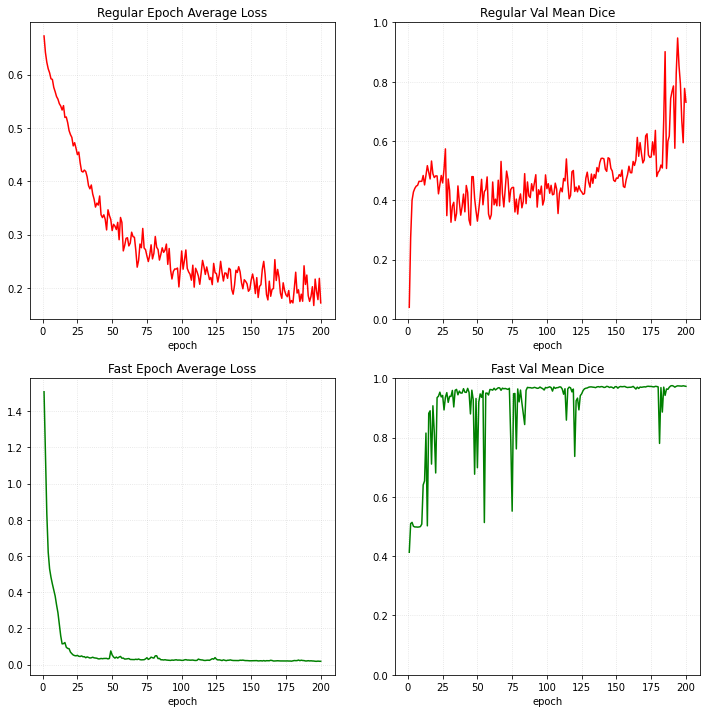

In [9]:
plt.figure("train", (12, 12))
plt.subplot(2, 2, 1)
plt.title("Regular Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.grid(alpha=0.4, linestyle=":")
plt.plot(x, y, color="red")

plt.subplot(2, 2, 2)
plt.title("Regular Val Mean Dice")
x = [i + 1 for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.ylim(0, 1)
plt.grid(alpha=0.4, linestyle=":")
plt.plot(x, y, color="red")

plt.subplot(2, 2, 3)
plt.title("Fast Epoch Average Loss")
x = [i + 1 for i in range(len(m_epoch_loss_values))]
y = m_epoch_loss_values
plt.xlabel("epoch")
plt.grid(alpha=0.4, linestyle=":")
plt.plot(x, y, color="green")

plt.subplot(2, 2, 4)
plt.title("Fast Val Mean Dice")
x = [i + 1 for i in range(len(m_metric_values))]
y = m_metric_values
plt.xlabel("epoch")
plt.ylim(0, 1)
plt.grid(alpha=0.4, linestyle=":")
plt.plot(x, y, color="green")
plt.show()

## Plot total time and every epoch time

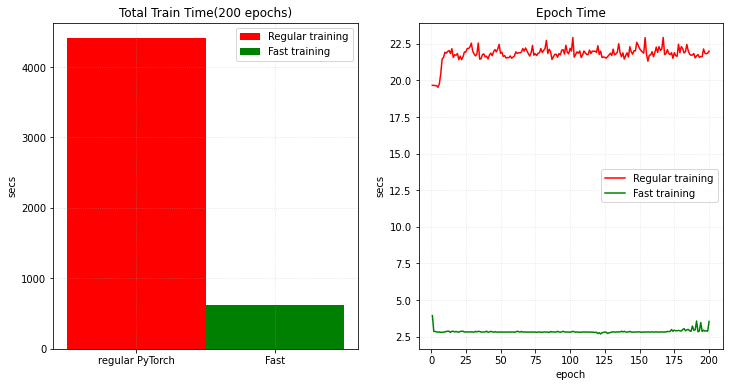

In [10]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Total Train Time(200 epochs)")
plt.bar(
    "regular PyTorch", total_time, 1, label="Regular training", color="red"
)
plt.bar("Fast", m_total_time, 1, label="Fast training", color="green")
plt.ylabel("secs")
plt.grid(alpha=0.4, linestyle=":")
plt.legend(loc="best")

plt.subplot(1, 2, 2)
plt.title("Epoch Time")
x = [i + 1 for i in range(len(epoch_times))]
plt.xlabel("epoch")
plt.ylabel("secs")
plt.plot(x, epoch_times, label="Regular training", color="red")
plt.plot(x, m_epoch_times, label="Fast training", color="green")
plt.grid(alpha=0.4, linestyle=":")
plt.legend(loc="best")
plt.show()

## Plot total time to achieve metrics

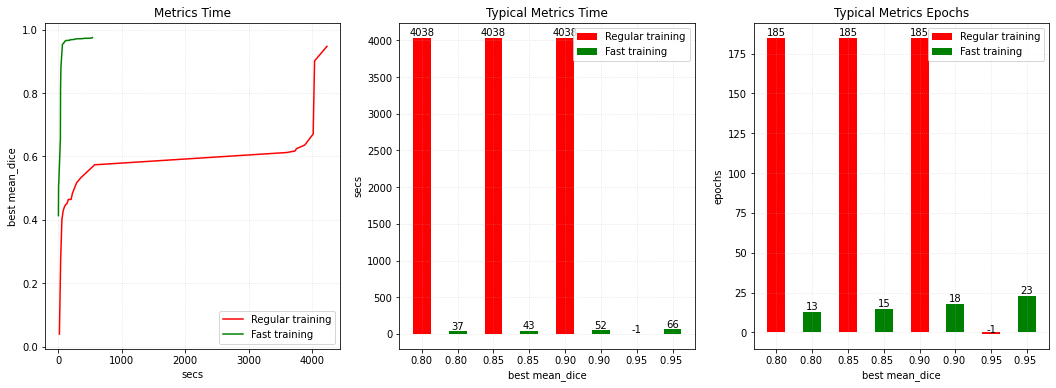

In [11]:
def get_best_metric_time(threshold, best_values):
    for i, v in enumerate(best_values[0]):
        if v > threshold:
            return best_values[2][i]
    return -1


def get_best_metric_epochs(threshold, best_values):
    for i, v in enumerate(best_values[0]):
        if v > threshold:
            return best_values[1][i]
    return -1


def get_label(index):
    if index == 0:
        return "Regular training"
    elif index == 1:
        return "Fast training"
    else:
        return None


plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Metrics Time")
plt.xlabel("secs")
plt.ylabel("best mean_dice")
plt.plot(best[2], best[0], label="Regular training", color="red")
plt.plot(m_best[2], m_best[0], label="Fast training", color="green")
plt.grid(alpha=0.4, linestyle=":")
plt.legend(loc="best")

plt.subplot(1, 3, 2)
plt.title("Typical Metrics Time")
plt.xlabel("best mean_dice")
plt.ylabel("secs")
labels = ["0.80", "0.80 ", "0.85", "0.85 ", "0.90", "0.90 ", "0.95", "0.95 "]
x_values = [0.8, 0.8, 0.85, 0.85, 0.9, 0.9, 0.95, 0.95]
for i, (l, x) in enumerate(zip(labels, x_values)):
    value = int(get_best_metric_time(x, best if i % 2 == 0 else m_best))
    color = "red" if i % 2 == 0 else "green"
    plt.bar(l, value, 0.5, label=get_label(i), color=color)
    plt.text(l, value, "%s" % value, ha="center", va="bottom")
plt.grid(alpha=0.4, linestyle=":")
plt.legend(loc="best")

plt.subplot(1, 3, 3)
plt.title("Typical Metrics Epochs")
plt.xlabel("best mean_dice")
plt.ylabel("epochs")
for i, (l, x) in enumerate(zip(labels, x_values)):
    value = int(get_best_metric_epochs(x, best if i % 2 == 0 else m_best))
    color = "red" if i % 2 == 0 else "green"
    plt.bar(l, value, 0.5, label=get_label(i), color=color)
    plt.text(l, value, "%s" % value, ha="center", va="bottom")
plt.grid(alpha=0.4, linestyle=":")
plt.legend(loc="best")
plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)